In [97]:
# encoding=utf8  
import sys,os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
from collections import Counter
import jieba,re
import pandas as pd
import numpy as np
%matplotlib inline

# 原始文件大小

In [98]:
pal = sns.color_palette()

print('# File sizes')
for f in os.listdir('./origin'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('./origin/' + f) / 1000000, 2)) + 'MB')

# File sizes
atec_nlp_sim_train.csv        3.0MB
atec_nlp_sim_train_add.csv    5.0MB


In [9]:
data_origin = pd.read_csv('./origin/atec_nlp_sim_train.csv',sep='\t',index_col=0,names=['A','B','label'])
data_add = pd.read_csv('./origin/atec_nlp_sim_train_add.csv',sep='\t',index_col=0,names=['A','B','label'])
data = pd.concat([data_origin,data_add],ignore_index=True)

# 重复数据分布

Total number of question pairs for training: 102477
Paraphrase pairs: 18.23%
Total number of questions in the training data: 198686
Number of questions that appear multiple times: 4705
()


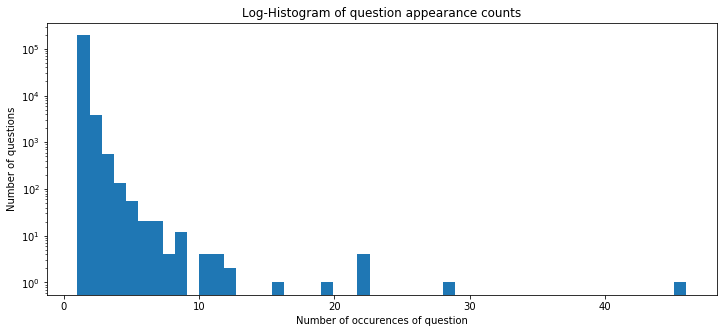

In [100]:
print('Total number of question pairs for training: {}'.format(len(data)))
print('Paraphrase pairs: {}%'.format(round(data['label'].mean()*100, 2)))
qids = pd.Series(data['A'].tolist() + data['B'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

# 全1提交
线上0.368
正例比例22.549%

# 预处理
## 1.分词

\*+转为\*

In [10]:
# encoding=utf-8
jieba.load_userdict("dict.txt")
data['seg_A'] = data['A'].apply(lambda x:' '.join(jieba.cut(x.strip(),cut_all=False)))
data['seg_B'] = data['B'].apply(lambda x:' '.join(jieba.cut(x.strip(),cut_all=False)))

pattern = re.compile(r'\*+')
data['Ax'] = data['A'].apply(lambda x:re.sub(pattern,'*',x))
data['Bx'] = data['B'].apply(lambda x:re.sub(pattern,'*',x))

data['seg_Ax'] = data['Ax'].apply(lambda x:' '.join(jieba.cut(x.strip(),cut_all=False)))
data['seg_Bx'] = data['Bx'].apply(lambda x:' '.join(jieba.cut(x.strip(),cut_all=False)))

#for name in data.columns:
#    data.to_csv(name+'.txt',columns=[name],index=None,encoding='utf-8',header=None)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/6f/g19plk_90w15fkvsklj6vy6r0000gn/T/jieba.cache
Loading model cost 1.109 seconds.
Prefix dict has been built succesfully.


## 2. 构建词典

In [138]:
c = Counter()
for line in pd.concat([data['seg_Ax'],data['seg_Bx']]):
    for word in line.strip().split():
        c[word] +=1

f_voc = codecs.open('vocab.txt','w',encoding='utf-8')
for key,f in sorted(c.items(), key=lambda x: x[1], reverse=True):
    f_voc.write(key+' '+str(f)+'\n')

f_voc.close()

## 3. 划分验证集

In [179]:
a=data[data.label==1].sample(frac=0.12363).index
b=data[data.label!=1].sample(frac=0.09472).index
valid_index = np.array(a.append(b))
np.save('valid_index.npy',valid_index)

# WordCloud

In [141]:
from wordcloud import WordCloud
train_qs = pd.concat([data['seg_Ax'],data['seg_Bx']])
cloud = WordCloud(font_path="/System/Library/Fonts/PingFang.ttc",width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

UnicodeEncodeError: 'ascii' codec can't encode character u'\ufeff' in position 0: ordinal not in range(128)

# 字符分析

In [91]:
qmarks = np.mean(train_qs.apply(lambda x: '？' in x))
star = np.mean(train_qs.apply(lambda x: '*' in x))
at = np.mean(train_qs.apply(lambda x: '@' in x))
fullstop = np.mean(train_qs.apply(lambda x: '。' in x))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))
en_qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
en_fullstop = np.mean(train_qs.apply(lambda x: '.' in x))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with English question marks: {:.2f}%'.format(en_qmarks * 100))
print('Questions with [*] tags: {:.2f}%'.format(star * 100))
print('Questions with [@] tags: {:.2f}%'.format(at * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with English full stops: {:.2f}%'.format(en_fullstop * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 0.77%
Questions with English question marks: 0.04%
Questions with [*] tags: 6.26%
Questions with [@] tags: 0.01%
Questions with full stops: 0.84%
Questions with English full stops: 0.08%
Questions with numbers: 0.02%


# 长度分布

In [11]:
data['len_A'] = data['seg_A'].apply(lambda x:len(x.split()))
data['len_B'] = data['seg_B'].apply(lambda x:len(x.split()))

In [12]:
data['len'] = data['len_A']+data['len_B']

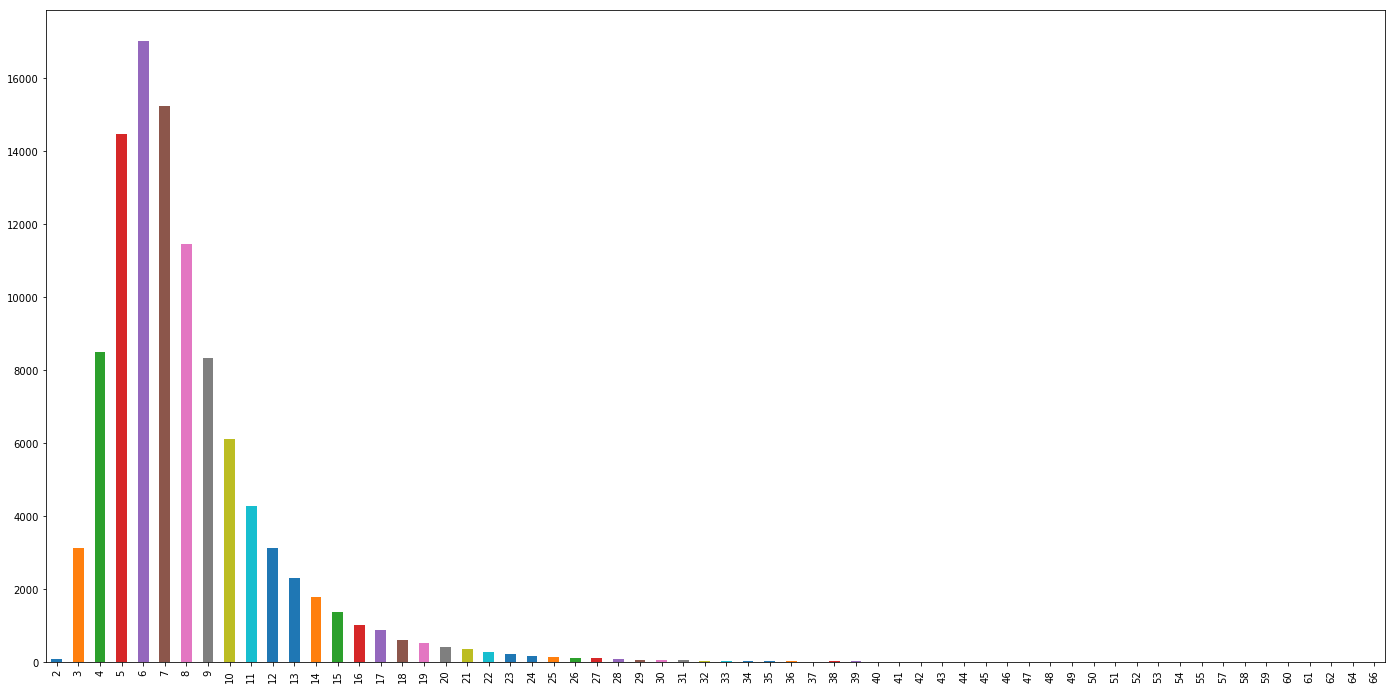

In [13]:
data.len_A.value_counts().sort_index().plot(kind='bar',figsize=(24,12))

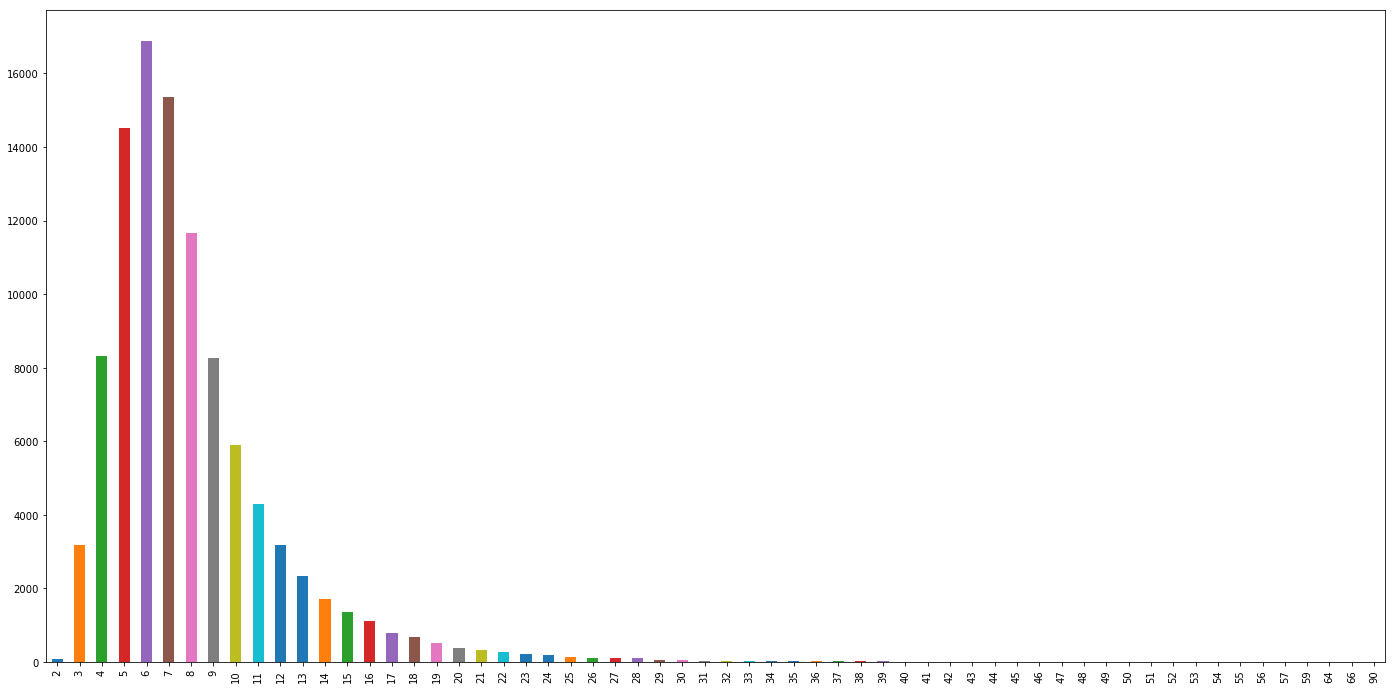

In [14]:
data.len_B.value_counts().sort_index().plot(kind='bar',figsize=(24,12))

In [15]:
data[(data.len_A>25) |(data.len_B>25)]

,A,B,label,seg_A,seg_B,Ax,Bx,seg_Ax,seg_Bx,len_A,len_B
42,上个月都用花呗，这个月也还款了，怎么还不能提额？是不是每个月都要用了一定的额度，才能提额,这个钱是***月的，退款之前我已经还清花呗了，现在不知怎么才能使用，现在买东西，花呗都是在我...,0,上个月 都 用 花呗 ， 这个 月 也 还款 了 ， 怎么 还 不能 提额 ？ 是不是 每个...,这个 钱 是 * * * 月 的 ， 退款 之前 我 已经 还清 花呗 了 ， 现在 不知 ...,上个月都用花呗，这个月也还款了，怎么还不能提额？是不是每个月都要用了一定的额度，才能提额,这个钱是*月的，退款之前我已经还清花呗了，现在不知怎么才能使用，现在买东西，花呗都是在我额度...,上个月 都 用 花呗 ， 这个 月 也 还款 了 ， 怎么 还 不能 提额 ？ 是不是 每个...,这个 钱 是 * 月 的 ， 退款 之前 我 已经 还清 花呗 了 ， 现在 不知 怎么 才...,29,39
73,我***月份花呗消费是***元，怎么要我还***元,我原本这个月总的花呗需要还***元，我还了一次***，又还了一个***，剩余的应该是***，...,1,我 * * * 月份 花呗 消费 是 * * * 元 ， 怎么 要 我 还 * * * 元,我 原本 这个 月 总 的 花呗 需要 还 * * * 元 ， 我 还 了 一次 * * *...,我*月份花呗消费是*元，怎么要我还*元,我原本这个月总的花呗需要还*元，我还了一次*，又还了一个*，剩余的应该是*，为何现在的是*，...,我 * 月份 花呗 消费 是 * 元 ， 怎么 要 我 还 * 元,我 原本 这个 月 总 的 花呗 需要 还 * 元 ， 我 还 了 一次 * ， 又 还 了...,21,57
169,以前的号码不用了？换了支付宝但是花呗还是之前的号码怎么办,我的花呗在以前的号码开通了。我现在换了新号码。以前的号码没有了。我用不了花呗是怎么回事,0,以前 的 号码 不用 了 ？ 换 了 支付宝 但是 花呗 还是 之前 的 号码 怎么办,我 的 花呗 在 以前 的 号码 开通 了 。 我 现在 换 了 新 号码 。 以前 的 号...,以前的号码不用了？换了支付宝但是花呗还是之前的号码怎么办,我的花呗在以前的号码开通了。我现在换了新号码。以前的号码没有了。我用不了花呗是怎么回事,以前 的 号码 不用 了 ？ 换 了 支付宝 但是 花呗 还是 之前 的 号码 怎么办,我 的 花呗 在 以前 的 号码 开通 了 。 我 现在 换 了 新 号码 。 以前 的 号...,16,28
175,我在淘宝上买个东西，用花呗买了，但是手机上面显示签收了，但是我没有收到货物，钱划了,我这是订了什么单，货没收到钱花呗显示扣***元,1,我 在 淘宝 上买个 东西 ， 用 花呗 买 了 ， 但是 手机 上面 显示 签收 了 ， ...,我 这 是 订 了 什么 单 ， 货 没收 到 钱 花呗 显示 扣 * * * 元,我在淘宝上买个东西，用花呗买了，但是手机上面显示签收了，但是我没有收到货物，钱划了,我这是订了什么单，货没收到钱花呗显示扣*元,我 在 淘宝 上买个 东西 ， 用 花呗 买 了 ， 但是 手机 上面 显示 签收 了 ， ...,我 这 是 订 了 什么 单 ， 货 没收 到 钱 花呗 显示 扣 * 元,26,19
192,我绑支付宝的银行卡坏了，在借呗上还有借款没还清，去银行换了新卡，旧卡报废了，怎么办？怎么还款,支付宝上的借呗怎么去查看,0,我 绑 支付宝 的 银行卡 坏 了 ， 在 借呗 上 还有 借款 没 还清 ， 去 银行 换...,支付宝 上 的 借呗 怎么 去 查看,我绑支付宝的银行卡坏了，在借呗上还有借款没还清，去银行换了新卡，旧卡报废了，怎么办？怎么还款,支付宝上的借呗怎么去查看,我 绑 支付宝 的 银行卡 坏 了 ， 在 借呗 上 还有 借款 没 还清 ， 去 银行 换...,支付宝 上 的 借呗 怎么 去 查看,30,7
202,银行卡的钱也少了，怎么花呗也让我还钱,我***月***日交了***元，和***元话费花呗让我还了***元。可我网银卡上怎么少了***元钱,0,银行卡 的 钱 也 少 了 ， 怎么 花呗 也 让 我 还 钱,我 * * * 月 * * * 日交 了 * * * 元 ， 和 * * * 元 话费 花呗...,银行卡的钱也少了，怎么花呗也让我还钱,我*月*日交了*元，和*元话费花呗让我还了*元。可我网银卡上怎么少了*元钱,银行卡 的 钱 也 少 了 ， 怎么 花呗 也 让 我 还 钱,我 * 月 * 日交 了 * 元 ， 和 * 元 话费 花呗 让 我 还 了 * 元 。 可...,14,43
220,我不知道怎么开通了花呗，该怎么取消,蚂蚁花呗，我不知道是什么时候把它开通了，我不想用了怎么能把它关掉吗，不想使用蚂蚁花呗的功能,0,我 不 知道 怎么 开通 了 花呗 ， 该 怎么 取消,蚂蚁 花呗 ， 我 不 知道 是 什么 时候 把 它 开通 了 ， 我 不想 用 了 怎么 ...,我不知道怎么开通了花呗，该怎么取消,蚂蚁花呗，我不知道是什么时候把它开通了，我不想用了怎么能把它关掉吗，不想使用蚂蚁花呗的功能,我 不 知道 怎么 开通 了 花呗 ， 该 怎么 取消,蚂蚁 花呗 ， 我 不 知道 是 什么 时候 把 它 开通 了 ， 我 不想 用 了 怎么 ...,11,31
255,为什么我的花呗刷脸说不是本人照片,为什么我信用额度都达到标准。花呗还是显示安全验证不成功。刷脸也说公安照片不清晰。这都是啥,0,为什么 我 的 花呗 刷 脸 说 不是 本人 照片,为什么 我 信用 额度 都 达到 标准 。 花呗 还是 显示 安全 验证 不 成功 。 刷 ...,为什么我的花呗刷脸说不是本人照片,为什么我信用额度都达到标准。花呗还是显示安全验证不成功。刷脸也说公安照片不清晰。这都是啥,为什么 我 的 花呗 刷 脸 说 不是 本人 照片,为什么 我 信用 额度 都 达到 标准 。 花呗 还是 显示 安全 验证 不 成功 。 刷 ...,10,29
280,我朋友手机丢了，暂时补办不了手机号，支付宝密码忘记了，这样的情况下，花呗里的钱怎么还,花呗还款时间到了，手机里没有钱，会怎么样,0,我 朋友 手机 丢 了 ， 暂时 补办 不了 手机号 ， 支付宝 密码 忘记 了 ， 这样 ...,花呗 还款 时间 到 了 ， 手机 里 没有 钱 ， 会 怎么样,我朋友手机丢了，暂时补办不了手机号，支付宝密码忘记了，这样的情况下，花呗里的钱怎么还,花呗还款时间到了，手机里没有钱，会怎么样,我 朋友 手机 丢 了 ， 暂时 补办 不了 手机号 ， 支付宝 密码 忘记 了 ， 这样 ...,花呗 还款 时间 到 了 ， 手机 里 没有 钱 ， 会 怎么样,27,13
350,今天还借呗钱，还之前还能借***元，还了***元多点，为什么还完能借的钱是***元，不应该是...,借呗额度是***元，现在全部借完了，未还本金是***元，不在了***元,0,今天 还 借呗 钱 ， 还 之前 还 能 借 * * * 元 ， 还 了 * * * 元 多...,借呗 额度 是 * * * 元 ， 现在 全部 借完 了 ， 未 还 本金 是 * * * ...,今天还借呗钱，还之前还能借*元，还了*元多点，为什么还完能借的钱是*元，不应该是*元加上*,借呗额度是*元，现在全部借完了，未还本金是*元，不在了*元,今天 还 借呗 钱 ， 还 之前 还 能 借 * 元 ， 还 了 * 元 多点 ， 为什么 ...,借呗 额度 是 * 元 ， 现在 全部 借完 了 ， 未 还 本金 是 * 元 ， 不 在 ...,46,29


# 长度差

In [16]:
data['len_diff'] = abs(data.len_A-data.len_B)

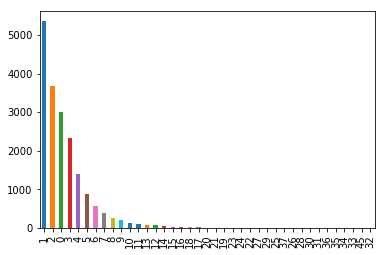

In [17]:
data[data.label==1]['len_diff'].value_counts().plot(kind='bar')

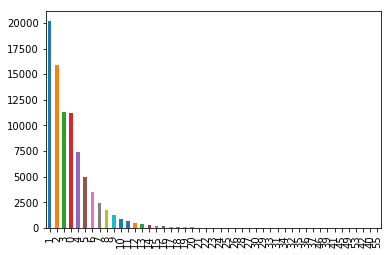

In [18]:
data[data.label==0]['len_diff'].value_counts().plot(kind='bar')

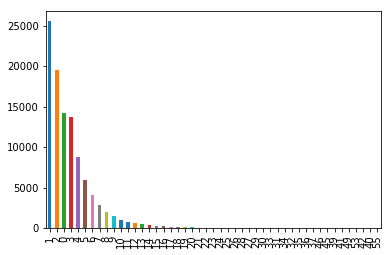

In [19]:
data['len_diff'].value_counts().plot(kind='bar')

# 初始特征分析

## 1. word overlap

In [67]:
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in list(row['A'].decode('utf-8')):
        q1words[word] = 1
    for word in str(row['A'].decode('utf-8')):
        q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = data.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[data['label'] == 0], bins=20, normed=True, label='Not Paraphrase')
plt.hist(train_word_match[data['label'] == 1], bins=20, normed=True, alpha=0.7, label='Paraphrase')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

UnicodeEncodeError: 'ascii' codec can't encode characters in position 0-9: ordinal not in range(128)

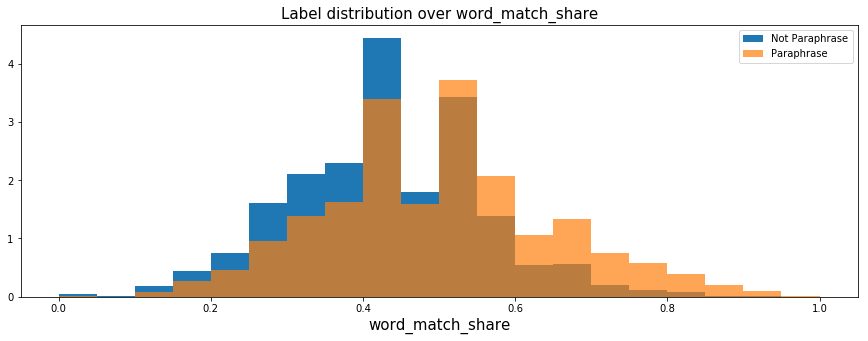

In [93]:
#from nltk.corpus import stopwords

#stops = set(stopwords.words("chinese"))
stops=[]
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['seg_A']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['seg_B']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = data.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[data['label'] == 0], bins=20, normed=True, label='Not Paraphrase')
plt.hist(train_word_match[data['label'] == 1], bins=20, normed=True, alpha=0.7, label='Paraphrase')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

## 2. tf-idf

In [143]:
from collections import Counter
train_qs = pd.concat([data['seg_Ax'], data['seg_Bx']])
# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [95]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('花呗', 6.287528686849634e-06), ('我', 1.3939419283792637e-05), ('借呗', 1.4017381553125876e-05), ('的', 1.4247043738424277e-05), ('了', 1.7400080040368186e-05), ('，', 1.7572221831728405e-05), ('吗', 1.9158556211203924e-05), ('还', 2.2167050895548856e-05), ('怎么', 2.2875443211712228e-05), ('还款', 2.3912003825920613e-05)]

Least common words and weights: 


[('\ufeff', 9.998000399920016e-05),
 ('没调', 9.998000399920016e-05),
 ('钱越', 9.998000399920016e-05),
 ('开看', 9.998000399920016e-05),
 ('半年前', 9.998000399920016e-05),
 ('付款人', 9.998000399920016e-05),
 ('新卡', 9.998000399920016e-05),
 ('接清', 9.998000399920016e-05),
 ('死亡', 9.998000399920016e-05),
 ('小票', 9.998000399920016e-05)]

In [98]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['seg_A']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['seg_B']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

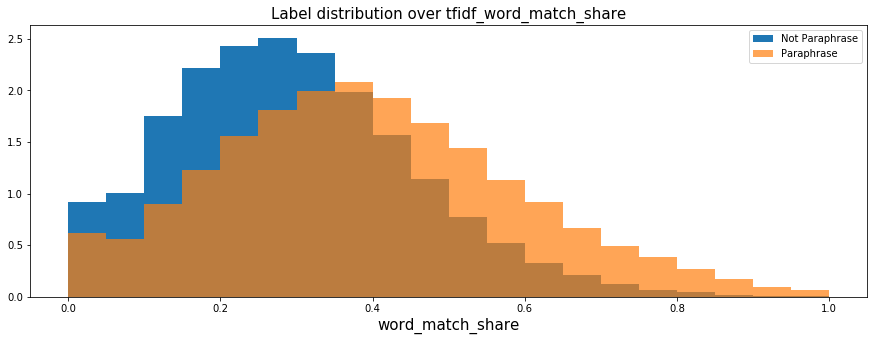

In [100]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = data.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[data['label'] == 0].fillna(0), bins=20, normed=True, label='Not Paraphrase')
plt.hist(tfidf_train_word_match[data['label'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Paraphrase')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

## 3. Edit Distance

In [109]:
def edit_distance(row):
    q1words = {}
    q2words = {}
    for word in row['seg_A'].lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in row['seg_B'].lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return max(len(q1words),len(q2words))
    a_sp = list(q1words.keys())
    b_sp = list(q2words.keys())
    dp = [[0 for _ in range(len(a_sp)+1)] for __ in range(len(b_sp)+1)]
    dp[0] = [i for i in range(len(a_sp)+1)]
    for i in range(len(b_sp)+1):
        dp[i][0] = i
    for i in range(len(b_sp)):
        for j in range(len(a_sp)):
            if a_sp[j]==b_sp[i]:
                temp=0
            else:
                temp=1
            dp[i+1][j+1] = min(dp[i][j]+temp,dp[i][j+1]+1,dp[i+1][j]+1)
    return dp[-1][-1]

In [139]:
plt.figure(figsize=(15, 5))
train_edit_distance = data.apply(edit_distance, axis=1, raw=True)
plt.hist(train_edit_distance[data['label'] == 0].fillna(0), bins=20, normed=True, label='Not Paraphrase')
plt.hist(train_edit_distance[data['label'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Paraphrase')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

/Users/richardbai/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  """
/Users/richardbai/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  


KeyboardInterrupt: 

In [109]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(data['label'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(data['label'], tfidf_train_word_match.fillna(0)))
print('      ED AUC:', roc_auc_score(data['label'], train_edit_distance.fillna(0)))

Original AUC: 0.6313935170662791
   TFIDF AUC: 0.6501991283486528
      ED AUC: 0.4089855637408205


## 4. LDA

In [40]:
import pandas as pd
import numpy as np
import codecs
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [133]:
stpwrdpath = "stop_words"
stpwrd_dic = open(stpwrdpath, 'rb')
stpwrd_content = stpwrd_dic.read()
stpwrdlst = stpwrd_content.splitlines()
for index, line in enumerate(codecs.open('vocab.txt', 'r', encoding='utf-8')):
    word, freq = line.split()
    if int(freq) <= 5:
        stpwrdlst.append(word)

In [55]:
data = pd.read_csv('seg_Ax.txt', sep='\t', header=None, names=['seg_Ax'], encoding='utf-8', dtype=str)
data['seg_Bx'] = pd.read_csv('seg_Bx.txt', header=None, encoding='utf-8', dtype=str)
data['label'] =  pd.read_csv('label.txt',header=None)
corpus = pd.concat([data['seg_Ax'], data['seg_Bx']])
cntVector = CountVectorizer(stop_words=stpwrdlst)
cntTf = cntVector.fit_transform(corpus)

In [60]:
lda = LatentDirichletAllocation(n_topics=30,
                                learning_offset=50.,
                                random_state=0)

docres = lda.fit_transform(cntTf)
lda_q1 = docres[:docres.shape[0]/2]
lda_q2 = docres[docres.shape[0]/2:]


/Users/richardbai/anaconda/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [57]:
from scipy.spatial import distance
lda_sim = [distance.cosine(x, y) for x,y in zip(lda_q1,lda_q2)]

In [58]:
lda_sim = pd.DataFrame(lda_sim)

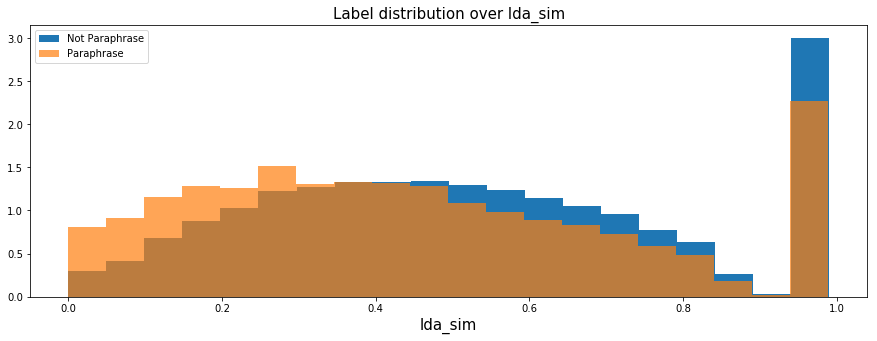

In [59]:
plt.figure(figsize=(15, 5))
plt.hist(lda_sim[data['label'] == 0].fillna(0), bins=20, normed=True, label='Not Paraphrase')
plt.hist(lda_sim[data['label'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Paraphrase')
plt.legend()
plt.title('Label distribution over lda_sim', fontsize=15)
plt.xlabel('lda_sim', fontsize=15)

In [48]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(data['label'], lda_sim))

('Original AUC:', 0.41555210248561247)
